# Assignment 2 - Classification of Australian Patent Applications

**Submission deadline: Friday <s>24 April</s> 1 May, 11pm**

**Penalty for late submission: 2 marks for each 24 period or part thereof**

**Assessment marks: 20 marks (20% of the total unit assessment)**

In this assignment you will design and evaluate several deep learning models that predict the type of Australian patent given the text of the patent application. This task and data were used in the 2018 Shared Task Competition of the Australasian Language Technology Association (the 2018 ALTA Challenge) and was hosted in Kaggle-in-Class

* [Link to download the data](https://www.kaggle.com/c/alta-2018-challenge/data)
* [Description of the 2018 ALTA Challenge](http://www.alta.asn.au/events/sharedtask2018/description.html)
* [Kaggle-in-class Competition Page](https://www.kaggle.com/c/alta-2018-challenge). Feel free to register and submit your runs!

The data set has the following files:
* `patents.zip` - The text of all patent applications. Once you unzipped, the files will be stored as individual files with the same name as the patent application ID.
* `train_data.csv` - The training set in a CSV file with annotations.
* `test_data.csv` - The test set in a CSV *without annotations*. We will not use this file for the assignment but feel free to use it to submit your runs to the ALTA 2018 Challenge if you wish.
* `samplesubmission.csv` - A sample submission file in the correct format. Again, we will not use this file for the assignment but it will be useful for you if you wish to submit runs to the ALTA 2018 Challenge.

**You are advised to start early and not to leave the exercises to the last minute since the total running time of the code may take many minutes**, depending on the hardware of your machine, and you may need to run parts of the code several times for testing and debugging.

## References:

I have used and adapted code from the below documents:
- W05L1-1-WordEmbeddings
- W02L2PageRank
- W03L1TextClassification
- W04L1-1-NN
- W04L102-MovieReviews
- https://www.tensorflow.org/tutorials/text/text_classification_rnn
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM#used-in-the-notebooks_1

In [2]:
import tensorflow as tf
tf.config.experimental.list_physical_devices()


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [4]:
from tensorflow import keras
keras.__version__

'2.2.4-tf'

The following code reads the training data from the [ALTA 2018 Challenge](https://www.kaggle.com/c/alta-2018-challenge/data). 

In [5]:
import pandas as pd
pd_data = pd.read_csv('train_data.csv')
pd_data[:5]

,id,first_ipc_mark_section
0,0,A
1,1,G
2,2,A
3,3,A
4,4,D


In [6]:
print("Number of samples:", len(pd_data))

Number of samples: 3972


The first column is the ID of the patent application, and the second column is the patent type. There are 8 types, from "A" to "G". The following code uses Pandas to count the label types:

In [7]:
pd_data['first_ipc_mark_section'].value_counts()

A    1303
G     781
C     637
B     442
H     330
E     287
F     178
D      14
Name: first_ipc_mark_section, dtype: int64

It will look nicer using a bar plot:

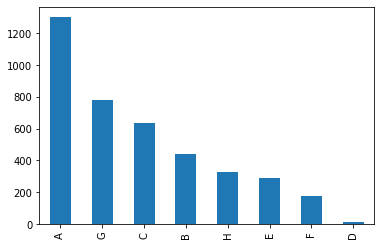

In [8]:
%matplotlib inline
pd_data['first_ipc_mark_section'].value_counts().plot.bar()

We can see that there is high imbalance in the data: The most popular class by far is "A", and class "D" is very rare.

Let's now unzip the file with the patents text, and display the beginning of one of them.

In [9]:
import zipfile, os
with zipfile.ZipFile('patents.zip', 'r') as z:
    z.extractall('.')

In [10]:
import os
print(os.listdir('patents')[:10])

['0.txt', '1.txt', '10.txt', '100.txt', '1000.txt', '1001.txt', '1002.txt', '1003.txt', '1004.txt', '1005.txt']


In [11]:
with open('patents/4763.txt', encoding='iso8859-1') as f:
    text = f.read()
print(text[:1000])

                                          ABSTRACT

        A wave pool for generating surfable waves is disclosed. The wave pool includes a

pool for containing water. The pool defines a channel having a first side wall, a second side

wall, and a bottom with a contour that slopes upward from a deep area proximate the first

side wall toward a sill defined by the second side wall. The wave pool further includes at

least one foil at least partially submerged in the water near the side wall, and being adapted

for movement by a moving mechanism in a direction along the side wall for generating a

wave in the channel that forms a breaking wave on the sill. The wave pool further includes

one or more passive flow control mechanisms to mitigate a mean flow of the water induced

by the movement of the at least one foil in the direction along the side wall.


             SURFACE GRAVITY WAVE GENERATOR AND WAVE POOL

                   CROSS REFERENCE TO RELATED APPLICATIONS

[0001]        

The following code converts the Pandas data frame into a list of pairs where the first element is the file name and the second element is the classification label:

In [12]:
ids = ['patents/'+str(i)+'.txt' for i in pd_data['id']]
labels = pd_data['first_ipc_mark_section']
all_data = list(zip(ids, labels))
all_data[:3]

[('patents/0.txt', 'A'), ('patents/1.txt', 'G'), ('patents/2.txt', 'A')]

The following code splits the data in to a training set, a devtest set, and a test set. We will use it to develop our classifiers.

In [13]:
import random
random.seed(1234)
random.shuffle(all_data)
train_data, devtest_data, test_data = all_data[:2500], all_data[2500:3300], all_data[3300:]
print('Length of the partitions:', len(train_data), len(devtest_data), len(test_data))

Length of the partitions: 2500 800 672


# Task 1 (1 mark) - Majority Baseline

We have seen that the most popular label is 'A'. Given that, determine the accuracy of a simple baseline classifier that classifies all patent applications with the label 'A'. Calculate the accuracy for the train data, the devtest data, and the test data. Write the answer below and your calculations.

In [14]:
import numpy as np
train_data_majority_baseline = float(np.sum(np.array(train_data) == 'A')) / len(train_data)
print('Accuracy of majority baseline in the train data:\n', train_data_majority_baseline)


Accuracy of majority baseline in the train data:
 0.3344


In [15]:
devtest_data_majority_baseline = float(np.sum(np.array(devtest_data) == 'A')) / len(devtest_data)
print('Accuracy of majority baseline in the devtest data:\n', devtest_data_majority_baseline)

Accuracy of majority baseline in the devtest data:
 0.3175


In [16]:
test_data_majority_baseline = float(np.sum(np.array(test_data) == 'A')) / len(test_data)
print('Accuracy of majority baseline in the test data:\n', test_data_majority_baseline)

Accuracy of majority baseline in the test data:
 0.3169642857142857


# Task 2 (2 marks) - Naive Bayes
Using scikit-learn, design a Naive Bayes classifier that uses tf.idf of the input words to classify the patent applications (*hint: If you have problems with the document encoding, use the option `encoding='iso8859-1'` when you create an instance of `TfidfVectorizer`*). Limit the number of words to 10000 (*hint: use the option `max_features=10000` to limit the number of words*)

In [17]:
# Write your solution here
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
import glob
files = glob.glob('patents/*.txt')

# create tfidf
tfidf = TfidfVectorizer(input='filename',
                        encoding='iso8859-1', 
                        max_features=10000,                        
                        stop_words='english')

def fit_transform_tfidf(filename):    
    file = glob.glob(filename)    
    tfidf_values = tfidf.fit_transform(file).toarray()
    return tfidf_values

def fit_tfidf(filename):
    file = glob.glob(filename)
    tfidf.fit(file)

def transform_tfidf(filename):
    file = glob.glob(filename)   
    tfidf_values = tfidf.transform(file).toarray()
    return tfidf_values

def binarize_label(values):
    return preprocessing.label_binarize(values, classes=['A','B','C','D','E','F','G','H'])

for name, label in train_data:
    fit_tfidf(name)


In [18]:
train_filenames, train_labels = zip(*train_data)
train_y = binarize_label(train_labels)
train_X = [transform_tfidf(n) for n in train_filenames]

In [19]:
def convert_array(arr):
    l = len(arr)
    new_arr = []
    for i in range(l):
        val = arr[i][0]
        new_arr.append(val)
    return new_arr

In [20]:
train_X = convert_array(train_X)

In [21]:
devtest_X, devtest_y = zip(*devtest_data)
devtest_X = [transform_tfidf(n) for n in devtest_X]
devtest_X = convert_array(devtest_X)

In [22]:

classifier = MultinomialNB()
classifier.fit(train_X, train_labels)
classifier.predict(devtest_X[:5])

array(['G', 'A', 'G', 'A', 'A'], dtype='<U1')

# Task 3 (2 marks) - Analysis of Naive Bayes

Report the accuracy of the Naive Bayes classifier on the training data, the dev-test data, and the test data, and answer the following questions:

1. Does the system improve on the majority baseline? Why?
2. Is the system overfitting? How can you determine this?

In [23]:
# Write your solution here
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [24]:
devtest_predictions = classifier.predict(devtest_X)
devtest_accuracy = accuracy_score(devtest_y, devtest_predictions)
print(devtest_accuracy)

train_accuracy_n = []
devtest_accuracy_n = []
for nsamples in range(100, 1600, 100):
    print("Processing %i samples" % nsamples)
    devtest_nsamples = int(nsamples/2)
    train_set_knn=train_data[:nsamples]
    devtest_set_knn=devtest_data[:devtest_nsamples]
    train_X_knn, train_y_knn = zip(*train_set_knn)
    train_X_knn = [transform_tfidf(n) for n in train_X_knn]
    train_X_knn = convert_array(train_X_knn)
    devtest_X_knn, devtest_y_knn = zip(*devtest_set_knn)
    devtest_X_knn = [transform_tfidf(n) for n in devtest_X_knn]
    devtest_X_knn = convert_array(devtest_X_knn)
    nb_classifier = MultinomialNB()
    nb_classifier.fit(train_X_knn, train_y_knn)
    devtest_predictions = nb_classifier.predict(devtest_X_knn)
    devtest_accuracy_n.append(accuracy_score(devtest_y_knn, devtest_predictions))
    train_predictions = nb_classifier.predict(train_X_knn)
    train_accuracy_n.append(accuracy_score(train_y_knn, train_predictions))
    

0.4825
Processing 100 samples
Processing 200 samples
Processing 300 samples
Processing 400 samples
Processing 500 samples
Processing 600 samples
Processing 700 samples
Processing 800 samples
Processing 900 samples
Processing 1000 samples
Processing 1100 samples
Processing 1200 samples
Processing 1300 samples
Processing 1400 samples
Processing 1500 samples


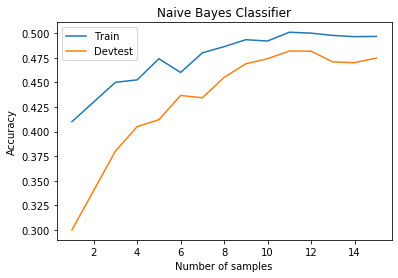

In [25]:
plt.plot(range(1,16), train_accuracy_n, label='Train')
plt.plot(range(1,16), devtest_accuracy_n, label='Devtest')
plt.xlabel('Number of samples')
plt.ylabel('Accuracy')
plt.title('Naive Bayes Classifier')
plt.legend()

*(Remember to answer the questions. Feel free to use this space for your answers.)*
1. This system does improve with an accuracy score of 0.5575
2. The system begins overfitting at 1200 samples as the accuracy of predicting the devtest data drops after this point

# Task 4 (5 marks) - Simple Neural Network

Implement a simple TensorFlow-Keras neural model that has the following sequence of layers:

1. An input layer that will accept tf.idf information
2. An output layer that can be used to classify the patent application into one of the 8 classes.

Train the layer with the tf.idf. (*Hint: sklearn produces sparse tf.idf matrices but TensorFlow models only accept dense matrices so you need to convert the tf_idf matrix of the training data into a dense Numpy array.*)

Train and test your system and report on the results. The report must answer the following questions:

1. How many parameters does the model have?
2. What was the optimal number of epochs? why?
3. Does your system overfit when training with the optimal number of epochs? How can you determine this?
4. How do the results compare against the majority baseline and the Naive Bayes implementation of Task 3?

#### Answers
1. Total parameters of the model is 1,297,801
2. The optimal number of epochs after testing turned out to be 5. This provided the highest accuracy
when evaluating test data while maintaining good accuracy on the devtest and test datasets
3. The system seems to be overfitting slightly as the accuracy of evaluating test data is lower than 
accuracy from trained data. Training set has 94% accuracy, and test set has 70% accuracy
4. Results are much more accurate than majority baseline and naive bayes implementation of task 3. Accuracy of 0.67 for this version
compared to 0.55 of naive bayes and majority baseline of 0.33

In [26]:
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

def encode_categories(labels):
    numbers = []
    for label in labels:
        number = ord(label) - 64
        numbers.append(number)
    return numbers

def decode_categories(numbers):
    labels = []
    for number in numbers:
        label = chr(number + 64)
        labels.append(label)
    return labels

In [27]:
one_hot_train_labels = to_categorical([encode_categories(l) for l in train_labels])
one_hot_devtest_labels = to_categorical([encode_categories(l) for l in devtest_y])
test_X, test_y = zip(*test_data)
test_X = [transform_tfidf(n) for n in test_X]
test_X = convert_array(test_X)
one_hot_test_labels = to_categorical([encode_categories(l) for l in test_y])

In [28]:
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1280128   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 1161      
Total params: 1,297,801
Trainable params: 1,297,801
Non-trainable params: 0
_________________________________________________________________


In [29]:
def get_words_from_file(filename):
    with open(filename, encoding='iso8859-1') as file:
        return file.read()

In [30]:


tf_tfidf = TfidfVectorizer(encoding='iso8859-1', max_features=10000, analyzer='word', stop_words='english')
filenames = [name for name, classification in train_data]
tfidf_transformed = tf_tfidf.fit_transform([get_words_from_file(name) for name in filenames]).toarray()



In [31]:
history = model.fit(tfidf_transformed, one_hot_train_labels, epochs=5, verbose=1, validation_split=0.2)


Train on 2000 samples, validate on 500 samples
Epoch 1/5
2000/2000 [==============================] - 1s 504us/sample - loss: 1.4854 - accuracy: 0.4785 - val_loss: 1.1449 - val_accuracy: 0.5720
Epoch 2/5
2000/2000 [==============================] - 0s 145us/sample - loss: 0.9139 - accuracy: 0.6885 - val_loss: 0.9467 - val_accuracy: 0.6460

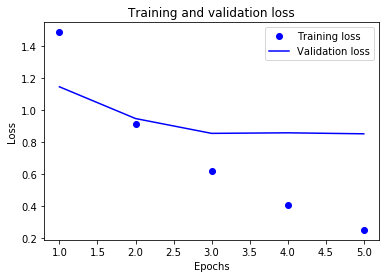

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

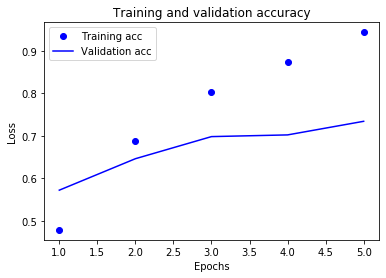

In [33]:
plt.clf()   # clear figure

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [34]:
devtest_filenames = [name for name, classification in devtest_data]
test_tfidf_transformed = tf_tfidf.transform([get_words_from_file(name) for name in devtest_filenames]).toarray()


In [35]:
print(model.evaluate(test_tfidf_transformed, one_hot_devtest_labels))

800/800 [==============================] - 0s 169us/sample - loss: 0.7961 - accuracy: 0.7400
[0.7961380290985107, 0.74]


In [36]:
test_filenames = [name for name, classification in test_data]
test_tfidf_transformed = tf_tfidf.transform([get_words_from_file(name) for name in test_filenames]).toarray()


In [37]:
print(model.evaluate(test_tfidf_transformed, one_hot_test_labels))

672/672 [==============================] - 0s 77us/sample - loss: 0.9518 - accuracy: 0.6577
[0.9518264815920875, 0.6577381]


In [38]:

model.predict(test_tfidf_transformed)

array([[1.5031544e-08, 5.9299462e-02, 1.4438316e-03, ..., 3.0120730e-04,
        1.9768274e-03, 5.3420266e-05],
       [2.9053601e-07, 2.5133695e-02, 4.6322894e-01, ..., 3.9893631e-02,
        2.0740116e-03, 7.2403997e-03],
       [1.9945746e-13, 1.9388799e-02, 2.4982433e-05, ..., 1.4343599e-06,
        8.2522783e-05, 1.2474912e-07],
       ...,
       [1.8376088e-08, 3.2629372e-04, 8.6257828e-04, ..., 3.6800582e-05,
        9.9601042e-01, 2.3892622e-03],
       [1.1249739e-05, 2.1908907e-02, 2.4440707e-01, ..., 7.3507719e-02,
        1.3289486e-01, 4.7982118e-01],
       [2.8757144e-08, 1.2032958e-01, 6.1009514e-01, ..., 7.6953575e-02,
        4.2872876e-04, 8.7027508e-04]], dtype=float32)

# Task 5 (5 marks) - Recurrent Neural Network

Implement a more complex neural network that is composed of the following sequence of layers:
* An embedding layer that generates embeddings with 50 dimensions. Note that the input to this layer must be a list of word indices. TensorFlow-Keras requires that this input list be of fixed length but the documents have a variable input length. For this exercise, use a fixed input length of 5000 words (*Hint: Use TensorFLow's `pad_sequences`*). Also, restrict the vocabulary to the 10000 most frequent words of the training set (*Hint: Use [Keras' tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) with the option `num_words=10000`*).
* A LSTM layer that generates an output of 60 dimensions.
* The final output layer that classifies the document into one of 8 classes.

To implement the classifier you may find useful to revise the lecture notes and associated notebooks of weeks 4 to 6. Also, refer to this [Keras Cheat Sheet](Keras_Cheat_Sheet_Python.pdf).

Train the system on the training data and evaluate the results. Compare your system with the previous systems and conduct the same kind of analysis that you did in Task 5.

#### Answers
1. Total parameters of the model is 527,189
2. The optimal number of epochs after testing turned out to be 12. This provided the highest accuracy
when evaluating test data that I could get when using these set layers
3. The system seems to be overfitting quite a lot as the accuracy of evaluating test data is significantly
lower than the accuracy of the training data
4. Results are still more accurate than majority baseline but lower than naive bayes implementation of task 3. Accuracy of 0.4 for this version
compared to 0.55 of naive bayes and majority baseline of 0.33

In [39]:
from tensorflow.keras.preprocessing import sequence, text

word_limit=10000
input_length=5000

embedding_layer = layers.Embedding(10000, 50, input_length=5000)

task5_model = models.Sequential()
task5_model.add(embedding_layer)
task5_model.add(layers.LSTM(60))
task5_model.add(layers.Dense(9, activation='softmax'))
task5_model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

task5_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 5000, 50)          500000    
_________________________________________________________________
lstm (LSTM)                  (None, 60)                26640     
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 549       
Total params: 527,189
Trainable params: 527,189
Non-trainable params: 0
_________________________________________________________________


In [40]:
task5_train_words = [get_words_from_file(n) for n in train_filenames]
task5_devtest_words = [get_words_from_file(n) for n in devtest_filenames]
task5_test_words = [get_words_from_file(n) for n in test_filenames]

In [41]:
tokenizer = text.Tokenizer(num_words=10000)
tokenizer.fit_on_texts(task5_train_words)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 434313 unique tokens.


In [42]:
task5_sequences = tokenizer.texts_to_sequences_generator(task5_train_words)
task5_sequences_padded = []
for s in task5_sequences:
    sequence_padded = sequence.pad_sequences([s], maxlen=5000, truncating='pre', padding='pre')
    task5_sequences_padded.append(sequence_padded)

task5_devtest_sequences = tokenizer.texts_to_sequences_generator(task5_devtest_words)
task5_devtest_sequences_padded = []
for s in task5_devtest_sequences:
    sequence_padded = sequence.pad_sequences([s], maxlen=5000, truncating='pre', padding='pre')
    task5_devtest_sequences_padded.append(sequence_padded)

task5_test_sequences = tokenizer.texts_to_sequences_generator(task5_test_words)
task5_test_sequences_padded = []
for s in task5_test_sequences:
    sequence_padded = sequence.pad_sequences([s], maxlen=5000, truncating='pre', padding='pre')
    task5_test_sequences_padded.append(sequence_padded)

In [43]:
import numpy as np
task5_sequences_padded = convert_array(task5_sequences_padded)
task5_sequences_padded = np.asarray(task5_sequences_padded)

task5_devtest_sequences_padded = convert_array(task5_devtest_sequences_padded)
task5_devtest_sequences_padded = np.asarray(task5_devtest_sequences_padded)

task5_test_sequences_padded = convert_array(task5_test_sequences_padded)
task5_test_sequences_padded = np.asarray(task5_test_sequences_padded)

In [44]:
task5_labels = np.asarray(one_hot_train_labels)
print('Shape of sequence tensor:', task5_sequences_padded.shape)
print('Shape of label tensor:', task5_labels.shape)

task5_devtest_labels = np.asarray(one_hot_devtest_labels)
print('Shape of devtest sequence tensor:', task5_devtest_sequences_padded.shape)
print('Shape of devtest label tensor:', task5_devtest_labels.shape)

task5_test_labels = np.asarray(one_hot_test_labels)
print('Shape of test sequence tensor:', task5_test_sequences_padded.shape)
print('Shape of test label tensor:', task5_test_labels.shape)

Shape of sequence tensor: (2500, 5000)
Shape of label tensor: (2500, 9)
Shape of devtest sequence tensor: (800, 5000)
Shape of devtest label tensor: (800, 9)
Shape of test sequence tensor: (672, 5000)
Shape of test label tensor: (672, 9)


In [45]:
task5_history = task5_model.fit(task5_sequences_padded, task5_labels,
                                epochs=10,
                                validation_split=-0.2)

Train on 2500 samples
Epoch 1/10
2500/2500 [==============================] - 14s 5ms/sample - loss: 1.8240 - accuracy: 0.3280

In [46]:
print(task5_model.evaluate(task5_devtest_sequences_padded, task5_devtest_labels))

800/800 [==============================] - 2s 2ms/sample - loss: 1.6000 - accuracy: 0.3900

In [47]:
print(task5_model.evaluate(task5_test_sequences_padded, task5_test_labels))

672/672 [==============================] - 1s 2ms/sample - loss: 1.5274 - accuracy: 0.4330

In [48]:
task5_model2 = models.Sequential()
task5_model2.add(embedding_layer)
task5_model2.add(layers.LSTM(60))
task5_model2.add(layers.Dense(9, activation='softmax'))
task5_model2.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

task5_model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 5000, 50)          500000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 60)                26640     
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 549       
Total params: 527,189
Trainable params: 527,189
Non-trainable params: 0
_________________________________________________________________


In [ ]:
task5_history2 = task5_model2.fit(task5_sequences_padded, task5_labels,
                                epochs=20,
                                validation_split=-0.2)

In [ ]:
print(task5_model2.evaluate(task5_devtest_sequences_padded, task5_devtest_labels))

In [ ]:
print(task5_model2.evaluate(task5_test_sequences_padded, task5_test_labels))

In [ ]:
task5_model3 = models.Sequential()
task5_model3.add(embedding_layer)
task5_model3.add(layers.LSTM(60))
task5_model3.add(layers.Dense(9, activation='softmax'))
task5_model3.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

task5_model3.summary()

In [ ]:
task5_history3 = task5_model3.fit(task5_sequences_padded, task5_labels,
                                epochs=12,
                                 validation_split=-0.2)

In [ ]:
print(task5_model3.evaluate(task5_devtest_sequences_padded, task5_devtest_labels))

In [ ]:
print(task5_model3.evaluate(task5_test_sequences_padded, task5_test_labels))

## Task 6 (5 marks)
This final exercise is open-ended. Try to improve the system, and write below the code of your experiments and your results. Explain what you do to try to improve the results, what worked and what did not work.

Some strategies that may (or may not) work:
* Change the number of hidden cells, change the number of hidden layers.
* Change the vocabulary size or the maximum text input length.
* Add more layers up to your discretion. Note that adding layers will slow down the system.
* Use pre-trained word embeddings.
* For further inspiration, read the following research papers:
   * ["Useful information" section at the ALTA 2018 Challenge](http://www.alta.asn.au/events/sharedtask2018/info.html)
   * System descriptions of some of the participants at the ALTA 2018 Challenge ([last 3 papers of the ALTA 2018 Proceedings](https://www.aclweb.org/anthology/events/alta-2018/))

Note that the best results by participants in the Kaggle in Class competition have an accuracy of 0.778 on Kaggle's private test set. So if you manage to get near 0.77 you are doing very well indeed!
* [Kaggle in Class leaderboard](https://www.kaggle.com/c/alta-2018-challenge/leaderboard)

For this exercise, it is important that you document what you are doing and explain your reasoning. We will value a good explanation, good error analysis and good motivation. You may obtain top marks even if your system did not do well, provided that your report in this section is sound. But you may obtain low marks in this exercise if the system does well but the report is of poor quality.

The rubric for assessing this task is as follows:
* Correct code (2 marks).
* Sound methodology and evaluation (2 marks).
* Sound explanations (1 marks).

In [ ]:
import zipfile
with zipfile.ZipFile('glove.6B.zip', 'r') as z:
    z.extractall('.')

In [ ]:
embeddings_index = {}
f = open('glove.6B.100d.txt', encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Found %s word vectors.' % len(embeddings_index))

In [ ]:
word_limit=10000
input_length=5000
embedding_dim = 100

embedding_matrix = np.zeros((word_limit, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < word_limit:
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

embedding_layer = layers.Embedding(word_limit, embedding_dim, input_length=5000)

In [ ]:
task6_model1 = keras.Sequential([
    embedding_layer,
    layers.Bidirectional(layers.LSTM(60, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(30)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(9, activation='softmax')
])
task6_model1.layers[0].set_weights([embedding_matrix])
task6_model1.layers[0].trainable = False
task6_model1.summary()

In [1]:
task6_model1.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

NameError: name 'task6_model1' is not defined

In [51]:
task6_history1 = task6_model1.fit(task5_sequences_padded, task5_labels,
                                epochs=10,
                                validation_split=-0.2)

Train on 2500 samples
Epoch 1/10
  96/2500 [>.............................] - ETA: 1:39 - loss: 2.1287 - acc: 0.1719

InternalError:  [_Derived_]  Failed to call ThenRnnBackward with model config: [rnn_mode, rnn_input_mode, rnn_direction_mode]: 2, 0, 0 , [num_layers, input_size, num_units, dir_count, max_seq_length, batch_size, cell_num_units]: [1, 100, 60, 1, 5000, 32, 60] 
	 [[{{node gradients/CudnnRNN_grad/CudnnRNNBackprop}}]]
	 [[StatefulPartitionedCall]] [Op:__inference_distributed_function_14419]

Function call stack:
distributed_function -> distributed_function -> distributed_function


In [54]:
%matplotlib inline

import matplotlib.pyplot as plt

loss = task6_history1.history['loss']
val_loss = task6_history1.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

NameError: name 'task6_history1' is not defined

In [48]:
print(task6_model1.evaluate(task5_devtest_sequences_padded, task5_devtest_labels))

800/800 [==============================] - 3s 4ms/sample - loss: 1.5777 - accuracy: 0.3713

In [49]:
print(task6_model1.evaluate(task5_test_sequences_padded, task5_test_labels))

672/672 [==============================] - 2s 2ms/sample - loss: 1.5606 - accuracy: 0.3854

# Submission of Results

Your submission should consist of this Jupyter notebook with all your code and explanations inserted into the notebook. The notebook should contain the output of the runs.

Examine the cells of this notebook so that you can have an idea of how to format text for good visual impact. You can also read this [useful guide to the MarkDown notation](http://daringfireball.net/projects/markdown/syntax), which explains the format of the text.

Each question specifies a mark. The final mark of the assignment is the sum of all the individual marks, after applying any deductions for late submission.

By submitting this assignment you are acknowledging that this is your own work. Any submissions that break the code of academic honesty will be penalised as per [the academic integrity policy](https://staff.mq.edu.au/work/strategy-planning-and-governance/university-policies-and-procedures/policies/academic-integrity).
